# BinWaves example in Cantabria (Propagation)

**In this notebook**: 
<br><br>
Here is where the construction of the library of pre-run cases for all the monochromatic wave systems is made.
<br><br>
Steps:
- Generates wave conditions for all given frequencies and directions.
- Generates SWAN cases and runs them.
- Extracts SWAN cases and saves output.
- Plots the library for all the cases and some larger example ones.

## Generate computational bathymetry

In [1]:
import xarray as xr

bathy = -(
    xr.open_dataset("outputs/bathymetry_100m.nc")
    .rename({"cx": "lon", "cy": "lat"})
    .transpose("lat", "lon")
    .isel(lon=slice(50, 500, 10), lat=slice(0, 350, 10))
    .sortby("lat", ascending=False)
    .elevation
)
bathy

<xarray.DataArray 'elevation' (lat: 35, lon: 45)> Size: 13kB
array([[1575.0794 , 1533.5016 , 1786.2909 , ..., 1105.2717 , 1253.9069 ,
        1626.1772 ],
       [1488.3802 , 1508.3778 , 1551.0946 , ...,  727.19432, 1050.9007 ,
        1356.7267 ],
       [1859.6714 , 1802.9953 , 1607.1499 , ...,  599.11487,  851.55784,
        1033.3446 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lon      (lon) float64 360B 4.092e+05 4.102e+05 ... 4.522e+05 4.532e+05
  * lat      (lat) float64 280B 4.835e+06 4.834e+06 ... 4.802e+06 4.801e+06

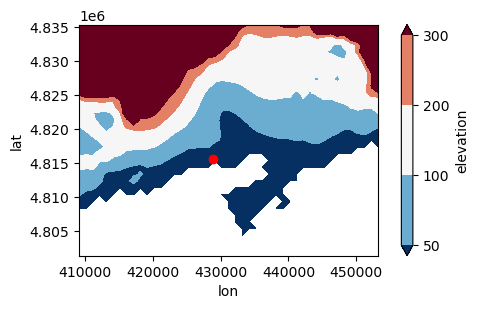

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3))
bathy.plot.contourf(ax=ax, levels=[50, 100, 200, 300])
ax.scatter(428845.10, 4815606.89, c="r")
ax.set_aspect("equal")

In [3]:
from bluemath_tk.topo_bathy.swan_grid import generate_grid_parameters

fixed_parameters = generate_grid_parameters(bathy_data=bathy)
fixed_parameters

{'xpc': 409188,
 'ypc': 4801379,
 'alpc': 0,
 'xlenc': 44000,
 'ylenc': 34000,
 'mxc': 44,
 'myc': 34,
 'xpinp': 409188.026,
 'ypinp': 4801379.317,
 'alpinp': 0,
 'mxinp': 44,
 'myinp': 34,
 'dxinp': 1000.0,
 'dyinp': 1000.0}

## Create SWAN cases

In [6]:
import numpy as np
from bluemath_tk.waves.binwaves import generate_swan_cases

# Generate swan model parameters
example_directions = [
    7.5,
    22.5,
    37.5,
    52.5,
    67.5,
    82.5,
    97.5,
    112.5,
    127.5,
    142.5,
    # 157.5,
    # 172.5,
    # 187.5,
    # 202.5,
    217.5,
    232.5,
    247.5,
    262.5,
    277.5,
    292.5,
    307.5,
    322.5,
    337.5,
    352.5,
]
example_frequencies = [
    0.035,
    0.0385,
    0.04235,
    0.046585,
    0.0512435,
    0.05636785,
    0.06200463,
    0.0682051,
    0.07502561,
    0.08252817,
    0.090781,
    0.0998591,
    0.10984501,
    0.12082952,
    0.13291247,
    0.14620373,
    0.1608241,
    0.17690653,
    0.19459718,
    0.21405691,
    0.2354626,
    0.25900885,
    0.28490975,
    0.31340075,
    0.3447408,
    0.37921488,
    0.4171364,
    0.45885003,
    0.50473505,
]
swan_cases_df = (
    generate_swan_cases(
        directions_array=example_directions,
        frequencies_array=example_frequencies,
    )
    .astype(float)
    .to_dataframe()
    .reset_index()
)
swan_cases_df

,dir,freq,hs,tp,spr,gamma
0,7.5,0.035000,1.0,28.5714,2.0,50.0
1,7.5,0.038500,1.0,25.9740,2.0,50.0
2,7.5,0.042350,1.0,23.6128,2.0,50.0
3,7.5,0.046585,1.0,21.4661,2.0,50.0
4,7.5,0.051243,1.0,19.5147,2.0,50.0
...,...,...,...,...,...,...
575,352.5,0.344741,0.1,2.9007,2.0,50.0
576,352.5,0.379215,0.1,2.6370,2.0,50.0
577,352.5,0.417136,0.1,2.3973,2.0,50.0
578,352.5,0.458850,0.1,2.1794,2.0,50.0


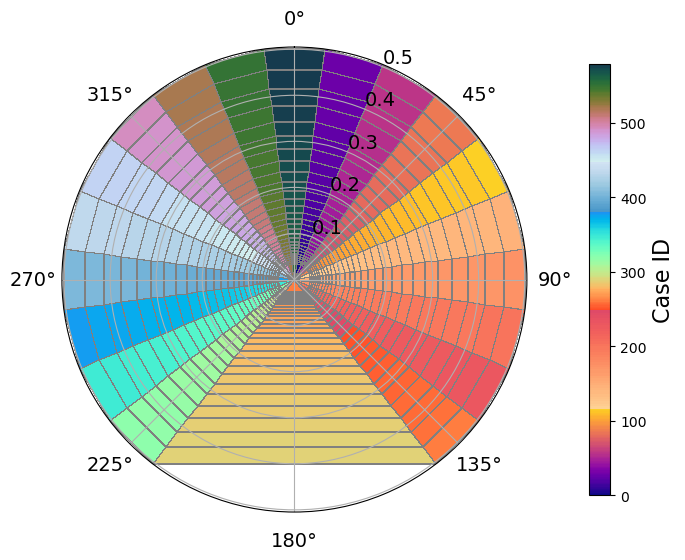

In [7]:
import numpy as np
from bluemath_tk.waves.binwaves import plot_selected_cases_grid

# Plot the cases grid

plot_selected_cases_grid(
    frequencies=np.array(example_frequencies),
    directions=np.array(example_directions),
    figsize=(8, 8),
)

## Build and run SWAN cases

In [8]:
import os
from bluemath_tk.wrappers.swan.swan_example import BinWavesWrapper

# Define the input templates and output directory for the wrapper

templates_dir = os.path.join(os.getcwd(), "templates")
templates_name = ["INPUT"]
output_dir = os.path.join(os.getcwd(), "CAN_cases")

# Create an instance of the SWAN model wrapper

swan_wrapper = BinWavesWrapper(
    templates_dir=templates_dir,
    templates_name=templates_name,
    metamodel_parameters=swan_cases_df.to_dict(orient="list"),
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_dataarray=bathy,
)

2025-03-27 18:48:32,184 - BinWavesWrapper - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-27 18:48:32,185 - BinWavesWrapper - WARNING - Parameter dir is not in the default_parameters
2025-03-27 18:48:32,185 - BinWavesWrapper - WARNING - Parameter freq is not in the default_parameters
2025-03-27 18:48:32,185 - BinWavesWrapper - WARNING - Parameter hs is not in the default_parameters
2025-03-27 18:48:32,186 - BinWavesWrapper - WARNING - Parameter tp is not in the default_parameters
2025-03-27 18:48:32,186 - BinWavesWrapper - WARNING - Parameter spr is not in the default_parameters
2025-03-27 18:48:32,186 - BinWavesWrapper - WARNING - Parameter gamma is not in the default_parameters


In [9]:
# Build the input files

swan_wrapper.build_cases(mode="one_by_one")
swan_cases_df.to_csv(os.path.join(output_dir, "swan_cases.csv"), index=False)

# Set the cases directories from the output directory
# Execute if the cases are already built

# swan_wrapper.set_cases_dirs_from_output_dir()

In [10]:
# Run the model

swan_wrapper.run_cases_in_background(launcher="docker_serial", num_workers=25)

In [14]:
# Monitor running cases

swan_wrapper.monitor_cases().iloc[-10:]

,Case,Percentage
570,0570,100 %
571,0571,100 %
572,0572,100 %
573,0573,100 %
574,0574,100 %
575,0575,100 %
576,0576,100 %
577,0577,100 %
578,0578,100 %
579,0579,100 %


In [15]:
# Post-process the output files

cases_bulk_parameters = swan_wrapper.postprocess_cases()
cases_bulk_parameters

<xarray.Dataset> Size: 11MB
Dimensions:   (case_num: 580, Yp: 35, Xp: 45)
Coordinates:
  * Xp        (Xp) float32 180B 4.092e+05 4.102e+05 ... 4.522e+05 4.532e+05
  * Yp        (Yp) float32 140B 4.801e+06 4.802e+06 ... 4.834e+06 4.835e+06
  * case_num  (case_num) int64 5kB 0 1 2 3 4 5 6 ... 573 574 575 576 577 578 579
Data variables:
    Hsig      (case_num, Yp, Xp) float32 4MB nan nan nan ... 0.1192 0.1192
    Tm02      (case_num, Yp, Xp) float32 4MB nan nan nan ... 1.212 1.212 1.212
    Dir       (case_num, Yp, Xp) float32 4MB nan nan nan nan ... 0.0 0.0 0.0 0.0

/home/tausiaj/GitHub-GeoOcean/BlueMath_tk/bluemath_tk/core/operations.py:342: RuntimeWarning: invalid value encountered in multiply
  x_rad = x_deg * np.pi / 180
/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


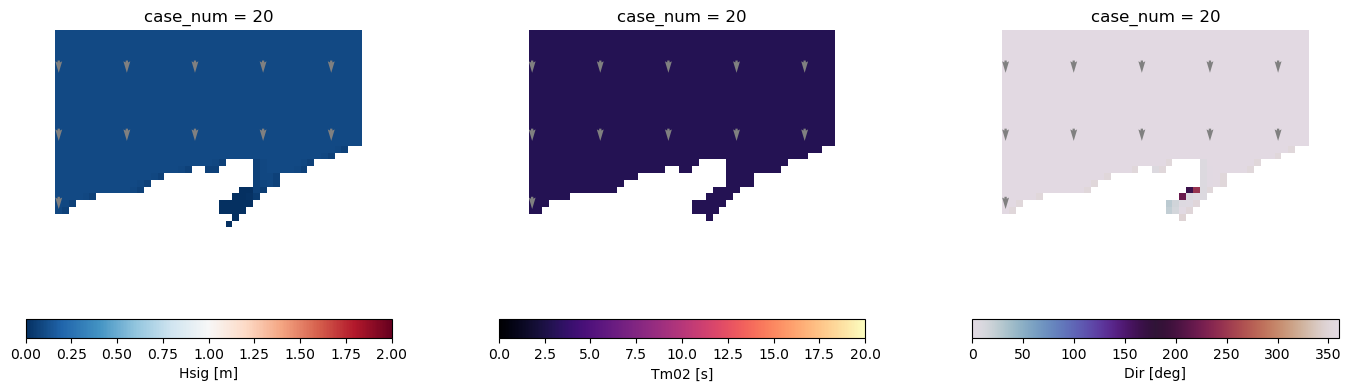

In [11]:
from utils.plotting import plot_case_variables

plot_case_variables(
    data=cases_bulk_parameters.isel(case_num=20),
)

## Plot ALL pre-run cases

"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argument (example: method='nearest')."
"not all values found in index 'case_num'. Try setting the `method` keyword argu

/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


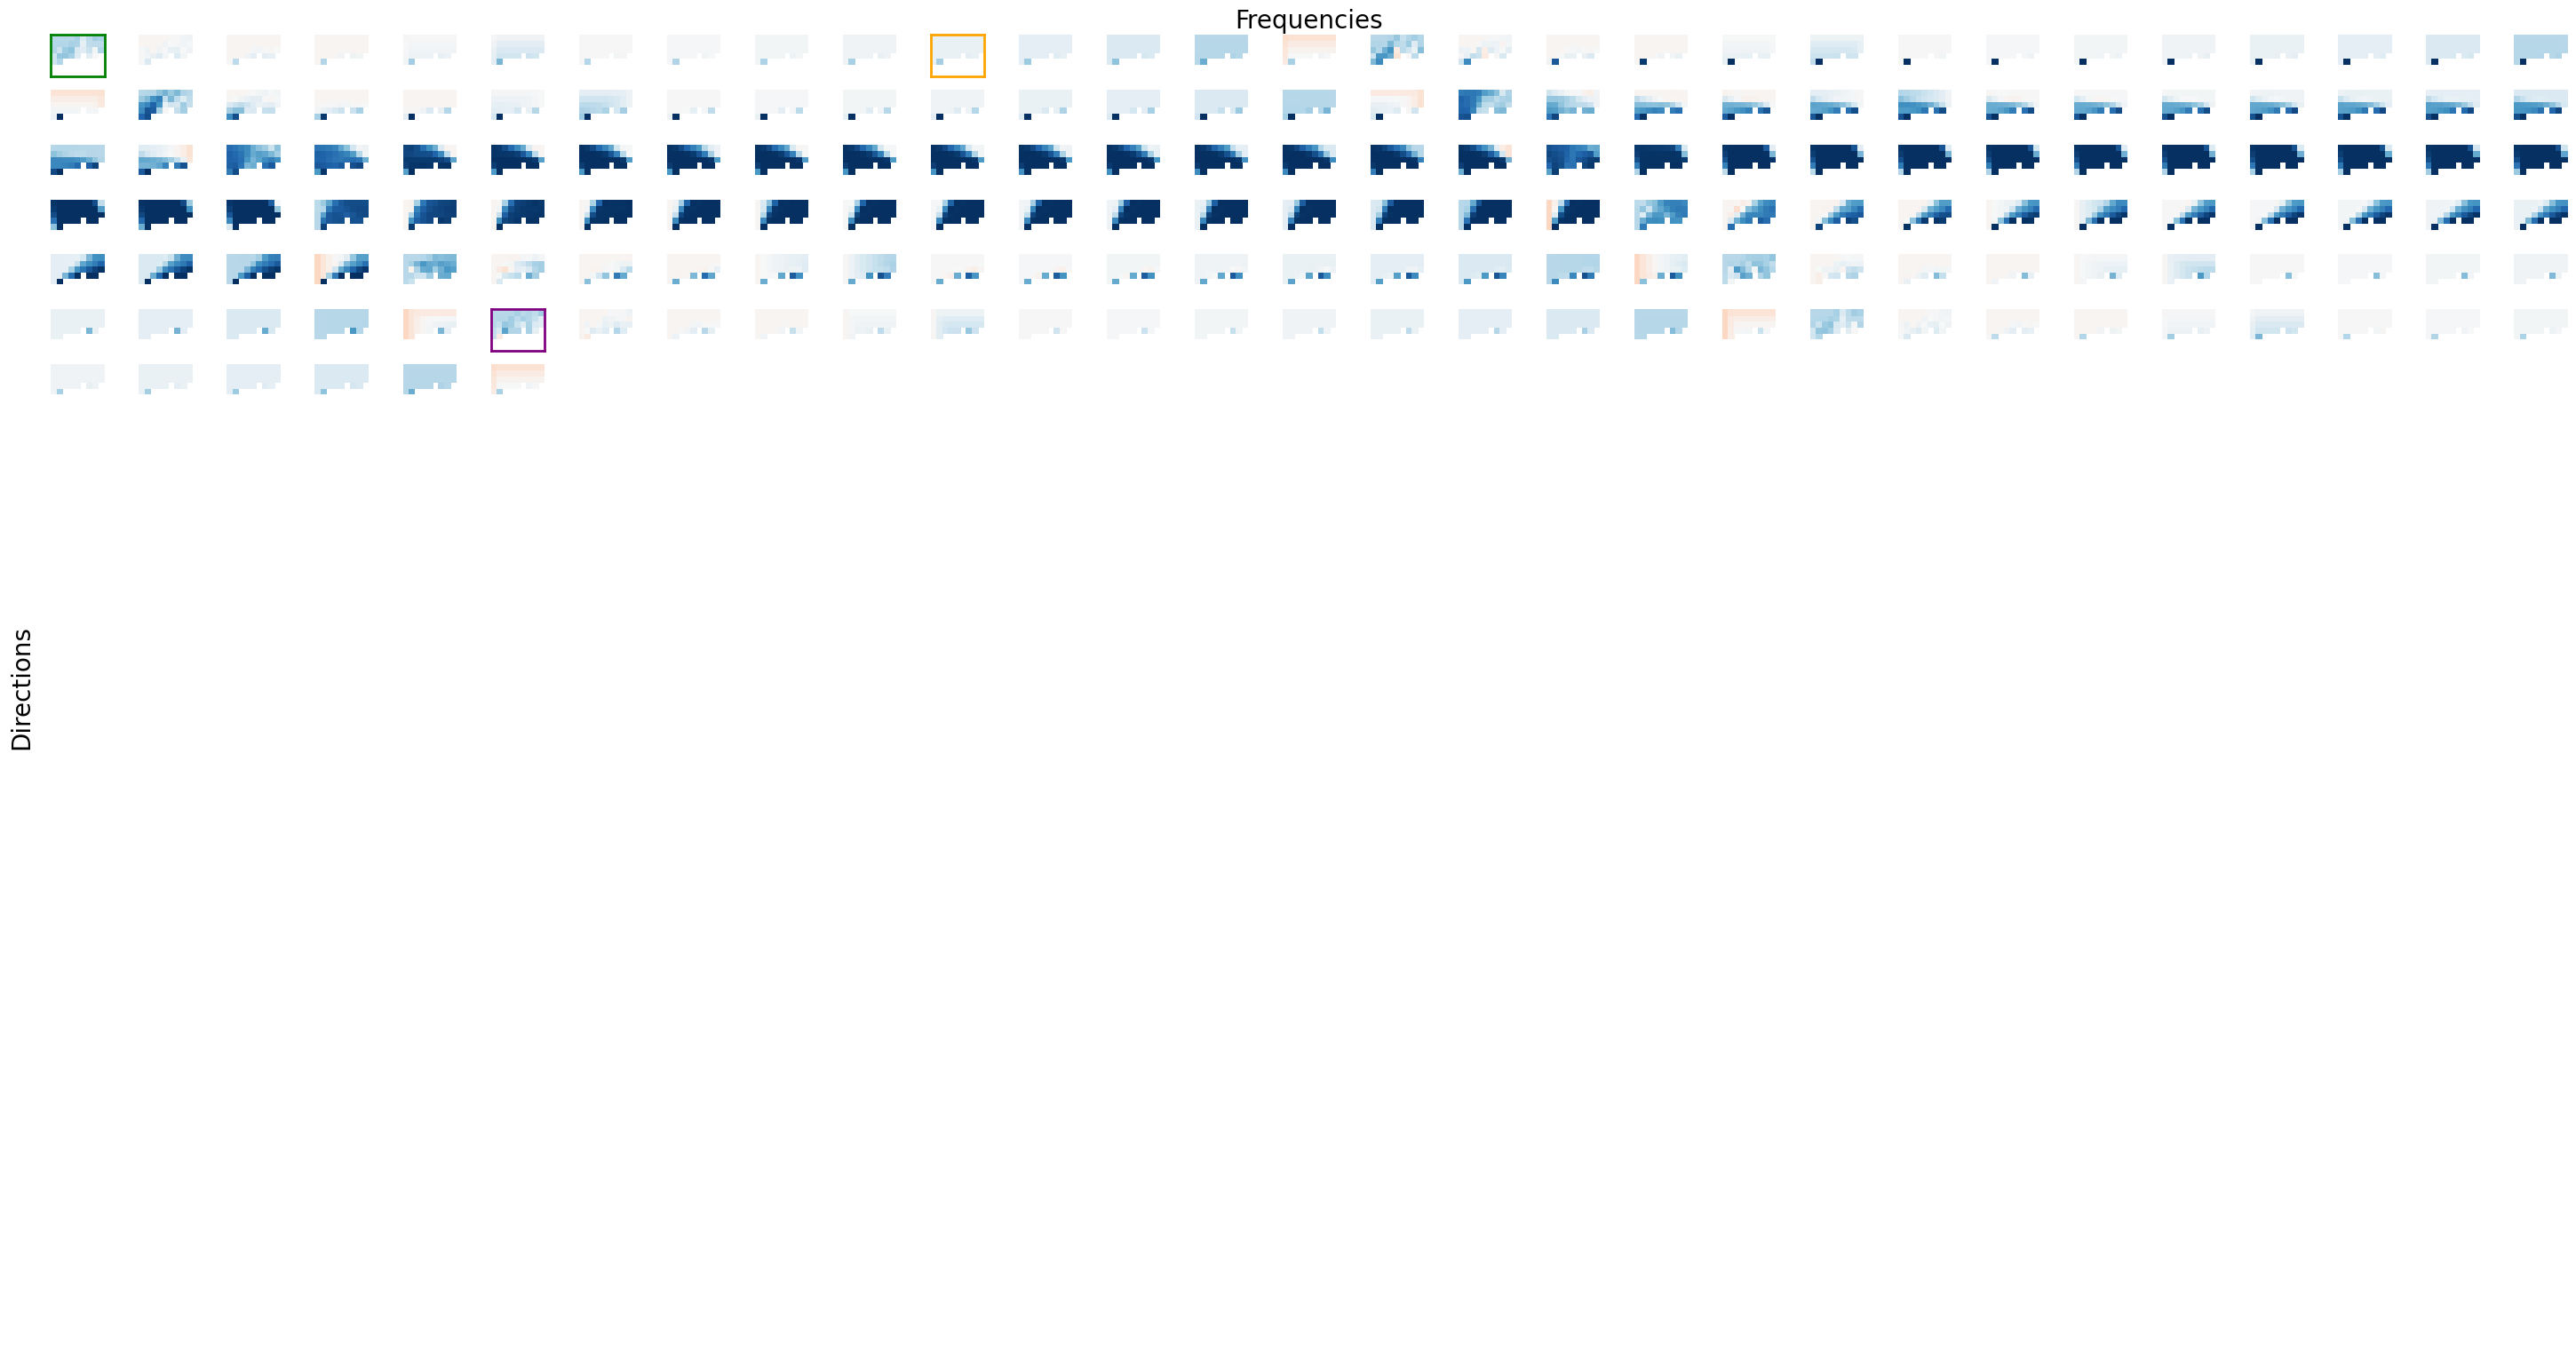

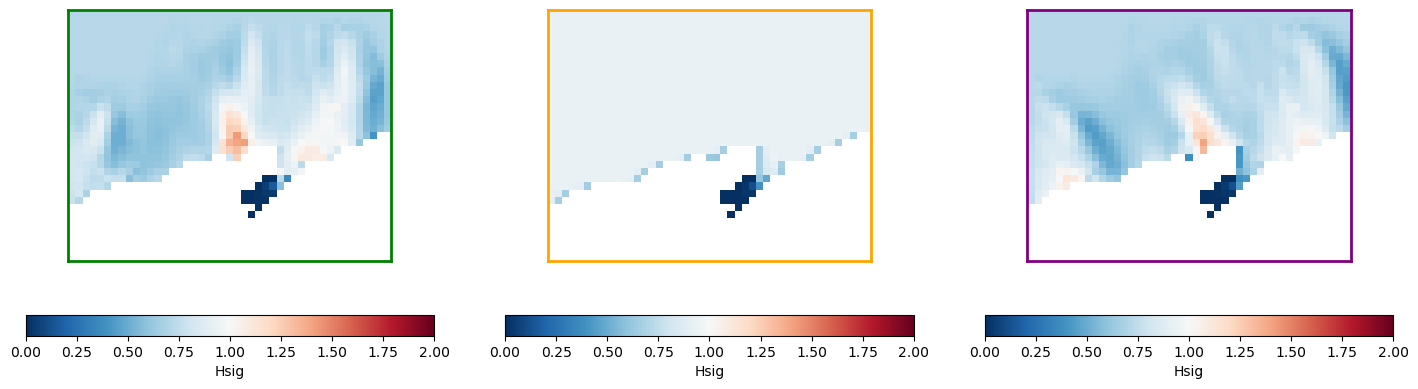

In [21]:
from utils.plotting import plot_cases_grid

plot_cases_grid(
    data=cases_bulk_parameters.Hsig.where(
        cases_bulk_parameters.case_num.isin(
            swan_cases_df.where(swan_cases_df["hs"] == 1.0).dropna().index.values
        ),
        cases_bulk_parameters.Hsig * 10,
    ),
    cases_to_plot=[0, 10, 150],
)

## Extract kp coefficients

In [16]:
from bluemath_tk.waves.binwaves import process_kp_coefficients

list_of_input_spectra = [
    os.path.join(case_dir, "input_spectra_N.bnd")
    for case_dir in swan_wrapper.cases_dirs
]
list_of_output_spectra = [
    os.path.join(case_dir, "output.spec") for case_dir in swan_wrapper.cases_dirs
]

kp_coefficients = process_kp_coefficients(
    list_of_input_spectra=list_of_input_spectra,
    list_of_output_spectra=list_of_output_spectra,
)
kp_coefficients

<xarray.DataArray 'efth' (case_num: 580, freq: 31, dir: 24)> Size: 3MB
array([[[0.08864658, 0.11105176, 0.00231358, ..., 0.32469246,
         0.60280893, 0.12712504],
        [0.07920962, 0.09704852, 0.00188739, ..., 0.25102325,
         0.55050988, 0.14344186],
        [0.07226888, 0.0829844 , 0.00152209, ..., 0.19074845,
         0.50405566, 0.16615146],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.09090991, 0.        , 0.        , ..., 0.        ,
         0.        , 0.19708758],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.06237022, 0.        , 0.        , ..., 0.        ,
         0.        , 0.13357724]]])
Coordinates:
  * case_num  (case_num) int64 5kB 0 1 2 3 4 5 6 ... 573 574 575 576 577 578 579
  * freq      (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    time      datetime64[ns] 8B 2025-03-27T18:50:00

In [17]:
kp_coefficients.to_dataset(name="kps").drop(["time"]).expand_dims(site=1).assign_coords(
    utm_x=(("site"), swan_wrapper.locations[:, 0]),
    utm_y=(("site"), swan_wrapper.locations[:, 1]),
).to_netcdf("outputs/kp_coefficients_NORTH.nc")

/tmp/ipykernel_1317044/323865776.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  kp_coefficients.to_dataset(name="kps").drop(["time"]).expand_dims(site=1).assign_coords(
